<a href="https://colab.research.google.com/github/hanhungchen/MachineLearning/blob/main/DebiasingFacialDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

此篇會透過建立臉部辨識模型，學習人臉圖像數據集中的潛在變數，並使用這些變數來自適應地重新採樣訓練數據，從而減輕可能存在的偏差（分類器在決策上因為觀察到額外的潛在特徵後產生了變化，即被認定是有偏差的），以便訓練一個無偏差的模型。
後續會呈現標準模型以及無偏差的模型兩者對於有偏差的資料集（例如人的膚色以及性別）訓練的精準度比較。

參考：[MIT 6.S191: Deep Generative Modeling](https://www.youtube.com/watch?v=3G5hWM6jqPk&list=PLtBw6njQRU-rwp5__7C0oIVt26ZgjG9NI&index=5)

Step 1.匯入套件

In [ ]:
%tensorflow_version 2.9
import tensorflow as tf

import IPython
import functools
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


Step 2.讀取訓練與測試資料集（來自 CelebA 與 ImageNet）。

In [ ]:
path_to_training_data = tf.keras.utils.get_file('train_face.h5', 'https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1')

1263889489/1263889489 [==============================] - 75s 0us/step


In [ ]:
import cv2
import h5py

from sklearn.model_selection import train_test_split

class ImageLoader:
  def __init__(self, path_to_data):
    # 打開 HDF5 文件
    with h5py.File(path_to_data, 'r') as h5_file:
      self.__max_not_face_index = 54956
      self.__min_face_index = 54957

      # 獲取 'images' 和 'labels' 資料集的內容
      images_data = h5_file['images'][:]
      labels_data = h5_file['labels'][:]

      face_images_data = images_data[self.__max_not_face_index:]
      face_labels_data = labels_data[self.__max_not_face_index:]
      not_face_images_data = images_data[: self.__min_face_index]
      not_face_labels_data = labels_data[: self.__min_face_index]

      # 取 20% 為測試資料
      self.__face_images_train, self.__face_images_test, self.__face_labels_train, self.__face_labels_test = train_test_split(face_images_data, face_labels_data, test_size = 0.2)
      self.__not_face_images_train, self.__not_face_images_test, self.__not_face_labels_train, self.__not_face_labels_test = train_test_split(not_face_images_data, not_face_labels_data, test_size = 0.2)

  def __get_train_face_data_size(self):
    return len(self.__face_labels_train)

  def __get_train_not_face_data_size(self):
    return len(self.__not_face_labels_train)

  def get_train_data_size(self):
    return self.__get_train_face_data_size() + self.__get_train_not_face_data_size()

  def __get_test_face_data_size(self):
    return len(self.__face_labels_test)

  def __get_test_not_face_data_size(self):
    return len(self.__not_face_labels_test)

  def get_test_data_size(self):
    return self.__get_test_face_data_size() + self.__get_test_not_face_data_size()

  def get_batch(self, num):
    # 臉部及非臉部的資料分別取一半
    face_num = num // 2
    not_face_num = num - face_num

    face_random_indices = np.random.choice(range(0, self.__get_train_face_data_size()), face_num, replace = False)
    not_face_random_indices = np.random.choice(range(0, self.__get_train_not_face_data_size()), not_face_num, replace = False)

    face_images_data = self.__face_images_train[face_random_indices]
    face_labels_data = self.__face_labels_train[face_random_indices]

    not_face_images_data = self.__not_face_images_train[not_face_random_indices]
    not_face_labels_data = self.__not_face_labels_train[not_face_random_indices]

    total_images = np.concatenate((face_images_data, not_face_images_data), axis=0)
    total_images_rgb = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in total_images]

    return np.array(total_images_rgb), np.concatenate((face_labels_data, not_face_labels_data), axis=0)


  def get_test_data(self, num):
    # 臉部及非臉部的資料分別取一半
    face_num = num // 2
    not_face_num = num - face_num

    face_random_indices = np.random.choice(range(0, self.__get_test_face_data_size()), face_num, replace = False)
    not_face_random_indices = np.random.choice(range(0, self.__get_test_not_face_data_size()), not_face_num, replace = False)

    face_images_data = self.__face_images_test[face_random_indices]
    face_labels_data = self.__face_labels_test[face_random_indices]

    not_face_images_data = self.__not_face_images_test[not_face_random_indices]
    not_face_labels_data = self.__not_face_labels_test[not_face_random_indices]

    total_images = np.concatenate((face_images_data, not_face_images_data), axis=0)
    total_images_rgb = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in total_images]

    return np.array(total_images_rgb), np.concatenate((face_labels_data, not_face_labels_data), axis=0)


實例化資料載入器

In [ ]:
loader = ImageLoader(path_to_training_data)

Step 3.檢測讀取資料是否正確對應 Labels，同時發現亮膚色女性出現最多其次是男性，再來是深膚色女性最後是男性。

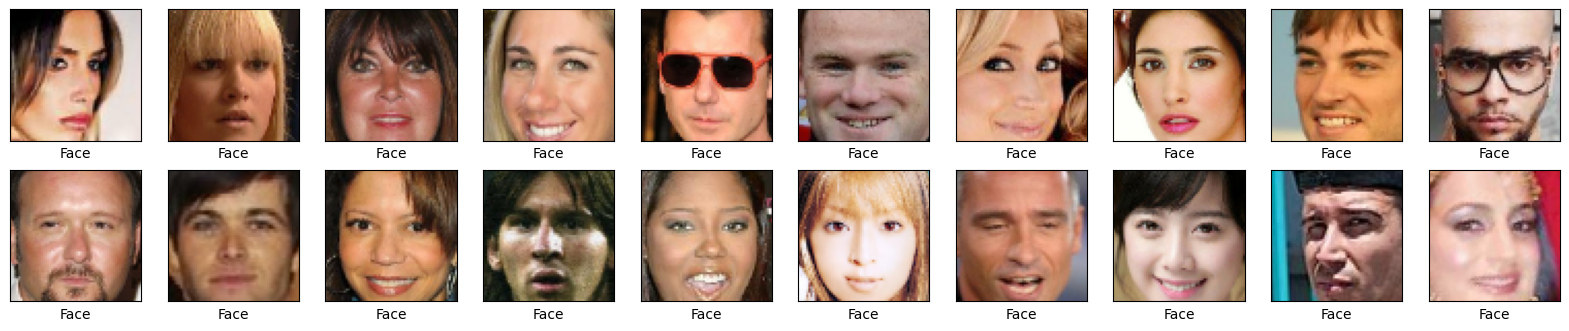

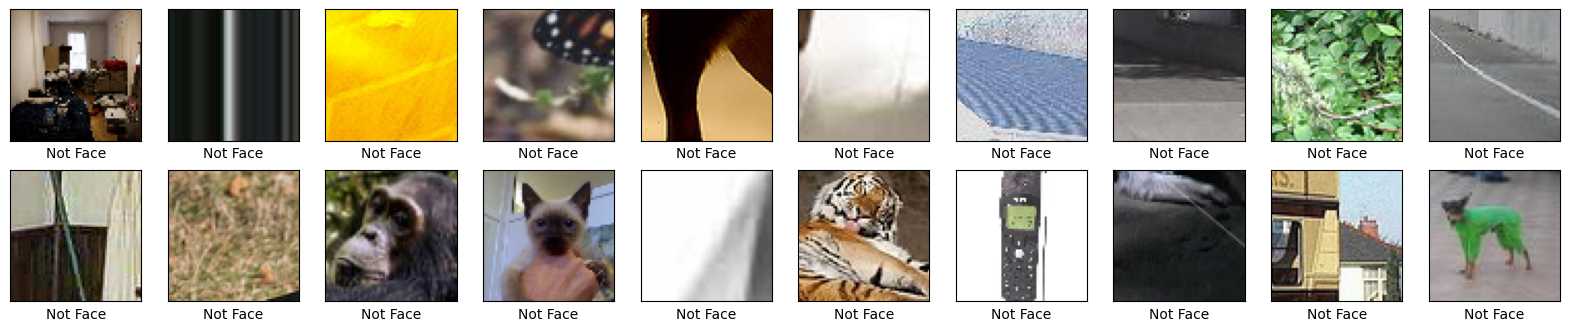

In [ ]:
num_rows = 4
num_cols = 10
num_images = num_rows * num_cols

images, labels = loader.get_batch(num_images)
face_images = images[np.where(labels==1)[0]]
not_face_images = images[np.where(labels==0)[0]]


# Face
plt.figure(figsize=(2*num_cols, 2*num_rows))
for i in range(len(face_images)):
  plt.subplot(num_rows, num_cols, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.xlabel("Face")
  plt.imshow(face_images[i])

# Not face
plt.figure(figsize=(2*num_cols, 2*num_rows))
for i in range(len(not_face_images)):
  plt.subplot(num_rows, num_cols, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.xlabel("Not Face")
  plt.imshow(not_face_images[i])

Step 4.建立 Debiasing Variational autoencoder (DB-VAE)模型，Encoder 以及 Ｄecoder，Encoder 負責訓練資料，Decoder 將訓練好的資料進行還原已達成無監督式的訓練目的。但 Debiasing Variational autoencoder 屬於半監督式的訓練模型，所以還是會使用到 Labels。

In [ ]:
n_filters = 12

def make_face_encoder(n_outputs = 1):
  Conv2D = functools.partial(tf.keras.layers.Conv2D, padding = 'same', activation = 'relu')
  BatchNormalzation = tf.keras.layers.BatchNormalization
  MaxPool2D = functools.partial(tf.keras.layers.MaxPool2D, padding = 'same')
  Flatten = tf.keras.layers.Flatten
  Dense = functools.partial(tf.keras.layers.Dense, activation = 'relu')

  model = tf.keras.Sequential([
      Conv2D(filters = n_filters, kernel_size = 5, strides = 2),
      BatchNormalzation(),
      MaxPool2D(pool_size = 2, strides = 2),

      Conv2D(filters = 2 * n_filters, kernel_size = 5, strides = 2),
      BatchNormalzation(),
      MaxPool2D(pool_size = 2, strides = 2),

      Conv2D(filters = 4 * n_filters, kernel_size = 3, strides = 2),
      BatchNormalzation(),
      MaxPool2D(pool_size = 2, strides = 2),

      Conv2D(filters = 6 * n_filters, kernel_size = 3, strides = 2),
      BatchNormalzation(),
      MaxPool2D(pool_size = 2, strides = 2),

      Flatten(),
      Dense(512),
      # 後續損失計算中使用 tf.nn.sigmoid_cross_entropy_with_logits 函式，將會結合 logits 和 sigmoid 函式的計算，因此不需要在輸出層上使用 sigmoid 激活函式。
      Dense(n_outputs, activation=None)
  ])

  return model

def make_face_decoder_network():
  Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, padding='same', activation='relu')
  Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
  Reshape = tf.keras.layers.Reshape

  decoder = tf.keras.Sequential([
    Dense(units = 4 * 4 * 6 * n_filters),
    Reshape(target_shape = (4, 4, 6 * n_filters)),

    # Filters 與 encoder 相反順序
    Conv2DTranspose(filters=4 * n_filters, kernel_size=3,  strides=2),  # 8 x 8
    Conv2DTranspose(filters=2 * n_filters, kernel_size=3,  strides=2),  # 16 x 16
    Conv2DTranspose(filters=1 * n_filters, kernel_size=5,  strides=2),  # 32 x 32
    Conv2DTranspose(filters=3, kernel_size=5,  strides=2),              # 64 x 64
  ])

  return decoder

In [ ]:
# 計算 VAE 損失
def vae_loss_function(x, x_recon, mu, logsigma, kl_weight = 0.0005):
  latent_loss = 0.5 * tf.reduce_sum(tf.exp(logsigma) + tf.square(mu) - 1.0 - logsigma, axis = 1)
  reconstruction_loss = tf.reduce_mean(tf.abs(x-x_recon), axis=(1,2,3))
  vae_loss = kl_weight * latent_loss + reconstruction_loss

  return vae_loss


# 消除偏差損失計算
def debiasing_loss_function(x, x_pred, y, y_logit, mu, logsigma):
  vae_loss = vae_loss_function(x, x_pred, mu, logsigma)
  classification_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_logit)

  face_indicator = tf.cast(tf.equal(y, 1), tf.float32)

  # 透過 face_indicator 達成若為臉部圖像則將 VAE loss 加入計算；否則，僅計算 Classification loss。
  total_loss = tf.reduce_mean(classification_loss + face_indicator * vae_loss)

  return total_loss, classification_loss, vae_loss

In [ ]:
class DB_VAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(DB_VAE, self).__init__()
    self.latent_dim = latent_dim

    # 定義 Encoder 的輸出量，含潛在變數量以及監督的分類結果
    num_encoder_dims = 2 * self.latent_dim + 1

    self.encoder = make_face_encoder(num_encoder_dims)
    self.decoder = make_face_decoder_network()

  def encode(self, x):
    encoder_output = self.encoder(x)
    # 分類預測結果
    y_logit = tf.expand_dims(encoder_output[:, 0], -1)
    # 潛在變數的分布參數
    z_mean = encoder_output[:, 1:self.latent_dim + 1]
    z_logsigma = encoder_output[:, self.latent_dim + 1:]

    return y_logit, z_mean, z_logsigma

  # VAE 使用“Reparameterization trick“對學習到的潛在變量進行採樣。
  def reparameterize(self, z_mean, z_logsigma):
    batch, latent_dim = z_mean.shape

    # 從高斯分佈中取 batch * laten_dim 隨機樣本
    epsilon = tf.random.normal(shape=(batch, latent_dim))

    # 解決 Backpropagate
    z = z_mean + tf.math.exp(0.5 * z_logsigma) * epsilon  # 透過指數處理標準差，確保其非負值

    return z

  def decode(self, z):
    reconstruction = self.decoder(z)

    return reconstruction

  def call(self, x):
    # 對輸入值進行編碼已取得預測值及潛在空間
    y_logit, z_mean, z_logsigma = self.encode(x)

    z = self.reparameterize(z_mean, z_logsigma)

    recon = self.decode(z)

    return y_logit, z_mean, z_logsigma, recon

  # 預測給定輸入 x 的臉或非臉
  def predict(self, x):
    y_logit, z_mean, z_logsigma = self.encode(x)

    return y_logit

Step 5.訓練 DB-VAE 模型

In [ ]:
learning_rate = 1e-3
batch_size = 32

db_vae = DB_VAE(100)
optimizer = tf.keras.optimizers.Adam(learning_rate)

@tf.function
def train_step(x, y):
  with tf.GradientTape() as tape:
    y_logit, z_mean, z_logsigma, x_recon  = db_vae(x)
    loss, class_loss, _ = debiasing_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma)

  grads = tape.gradient(loss, db_vae.trainable_variables)
  optimizer.apply_gradients(zip(grads, db_vae.trainable_variables))

  return loss

def compute_accuracy(loader):
  batch_x, batch_y = loader.get_batch(batch_size)
  y_logit, _, _, _  = db_vae(x)
  y_pred = tf.round(tf.nn.sigmoid(y_logit))
  acc = tf.reduce_mean(tf.cast(tf.equal(y_pred, batch_y), tf.float32))

  return acc

反覆訓練收斂，呈現逐個 Epoch 損失及精準度。

In [ ]:
loss_history = []
n_epochs = 6

if hasattr(tqdm, '_instances'): tqdm._instances.clear()

for epoch in range(n_epochs):
  print(f'Epoch: {epoch + 1} / {n_epochs}')
  for iter in tqdm(range(loader.get_train_data_size() // batch_size)):
    x, y = loader.get_batch(batch_size)
    x_float = x.astype(np.float32) / 255
    y_float = y.astype(np.float32)
    loss = train_step(x_float, y_float)

    loss_history.append(loss.numpy().mean())

  np_loss_history = np.array(loss_history)
  print(f'\nloss: {np_loss_history.mean(): .4f} - accuracy: {compute_accuracy(loader): .4f}')

Epoch: 1 / 6


100%|██████████| 2747/2747 [06:07<00:00,  7.47it/s]



loss:  0.1281 - accuracy:  1.0000
Epoch: 2 / 6


100%|██████████| 2747/2747 [05:59<00:00,  7.63it/s]



loss:  0.1072 - accuracy:  1.0000
Epoch: 3 / 6


100%|██████████| 2747/2747 [06:02<00:00,  7.57it/s]



loss:  0.0965 - accuracy:  1.0000
Epoch: 4 / 6


100%|██████████| 2747/2747 [05:54<00:00,  7.75it/s]



loss:  0.0901 - accuracy:  1.0000
Epoch: 5 / 6


100%|██████████| 2747/2747 [05:58<00:00,  7.67it/s]



loss:  0.0859 - accuracy:  0.9688
Epoch: 6 / 6


100%|██████████| 2747/2747 [05:53<00:00,  7.76it/s]



loss:  0.0825 - accuracy:  1.0000


Final Step.測試模型訓練結果

測試１：將同一批資料（資料數量由膚色白→黑；男→女，以此類推減少）經過標準 CNN 以及 DB-VAE 模型訓練，完成之後，輸入不同群組的資料集（如下圖；資料來源：Mit Deep Learning Lib）分別進行分類預測，觀察兩模型下各群組的精準度。

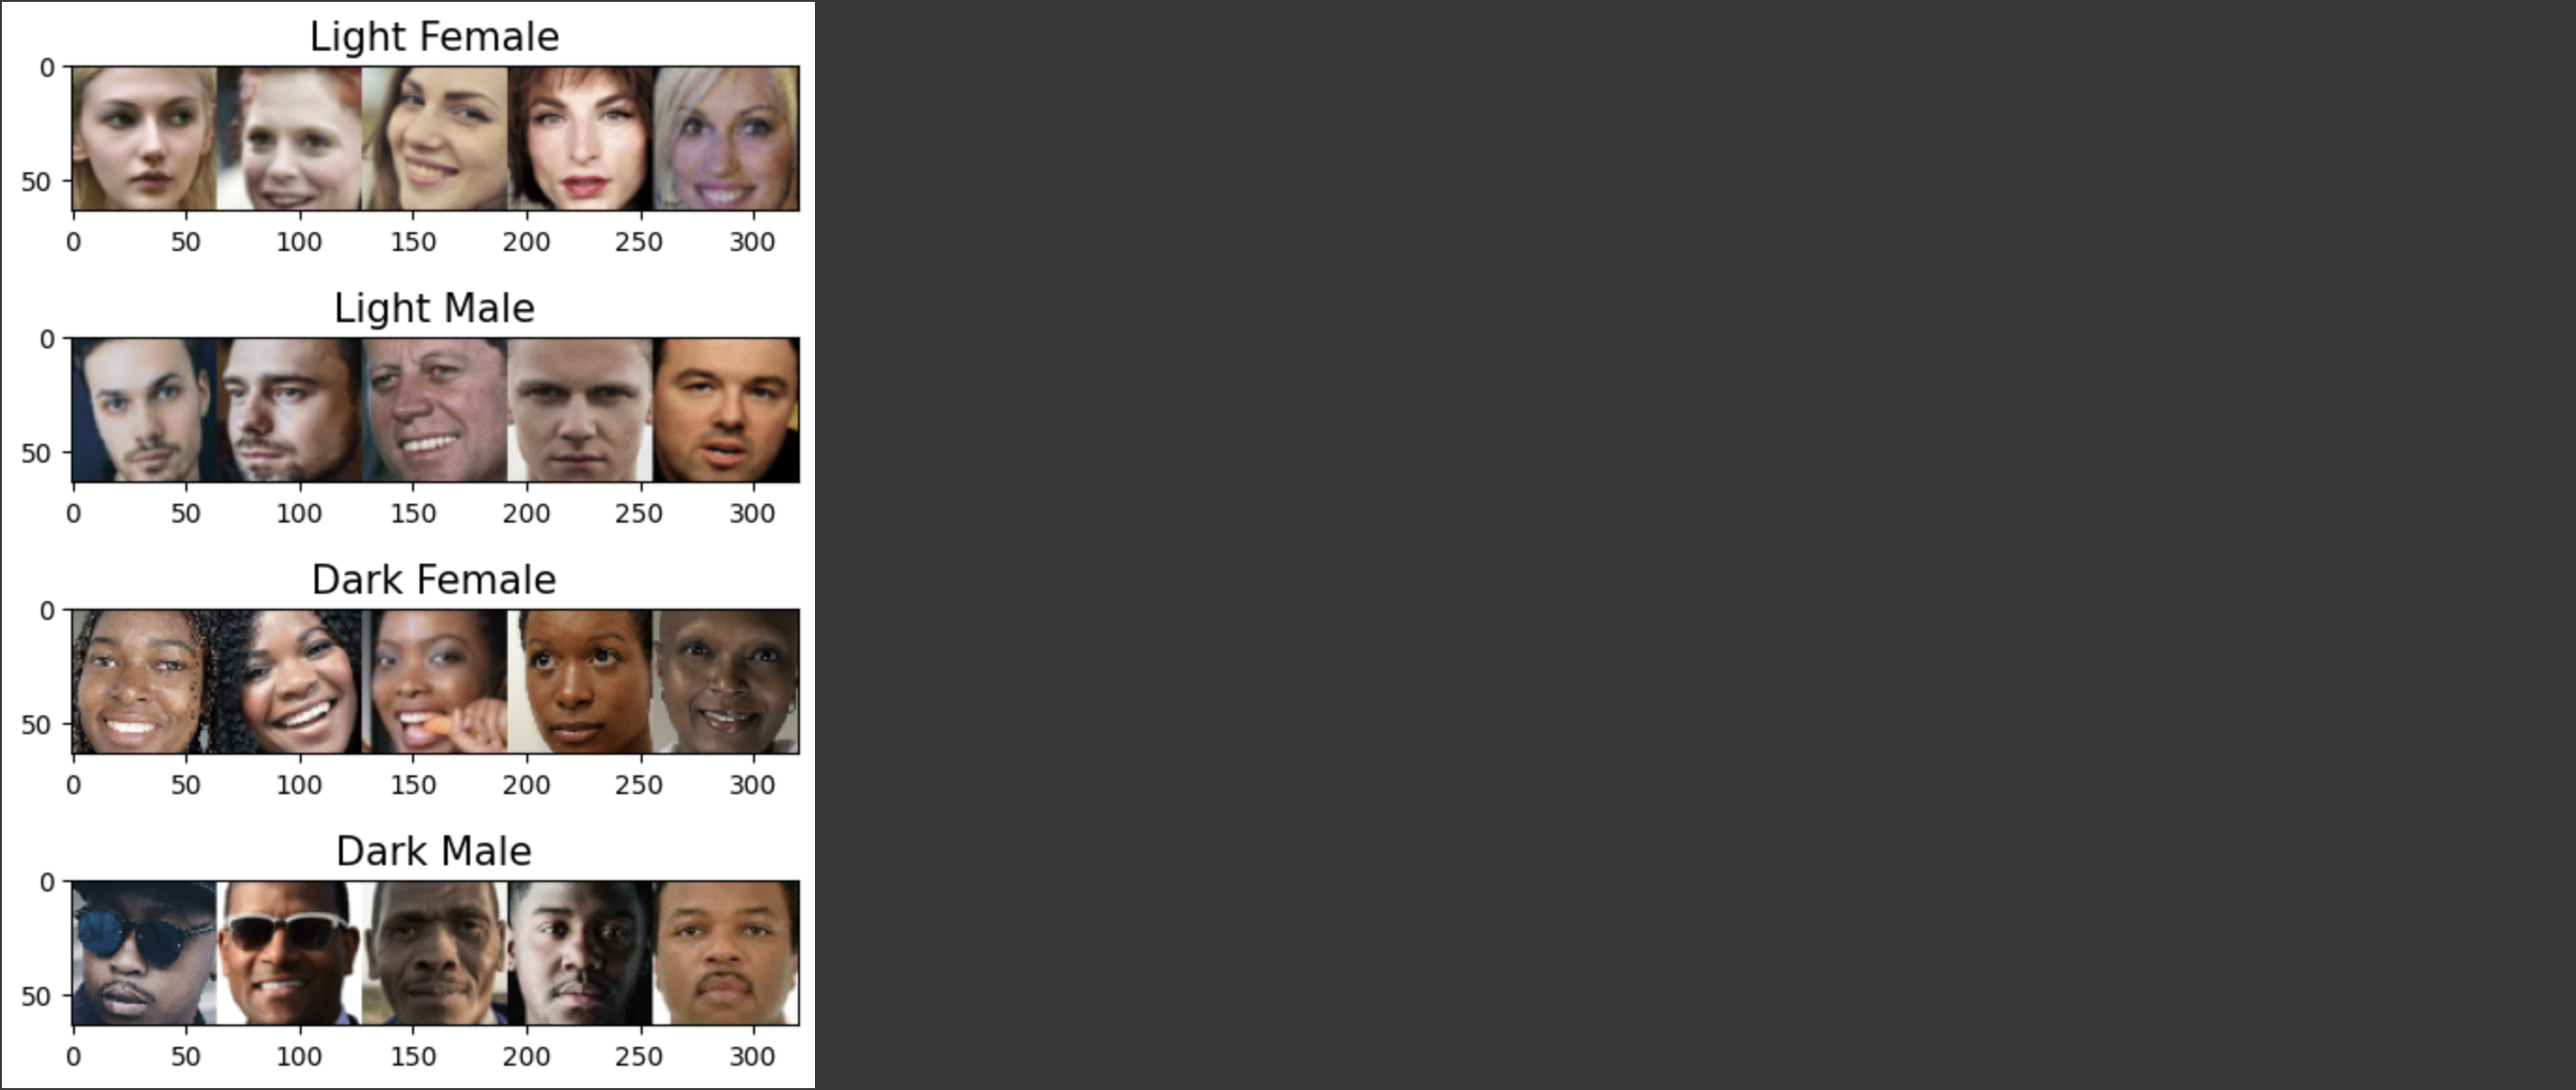

A. 標準的 CNN 模型測試結果，可以發現因取樣不平衡導致資料量越稀有精確度越低。



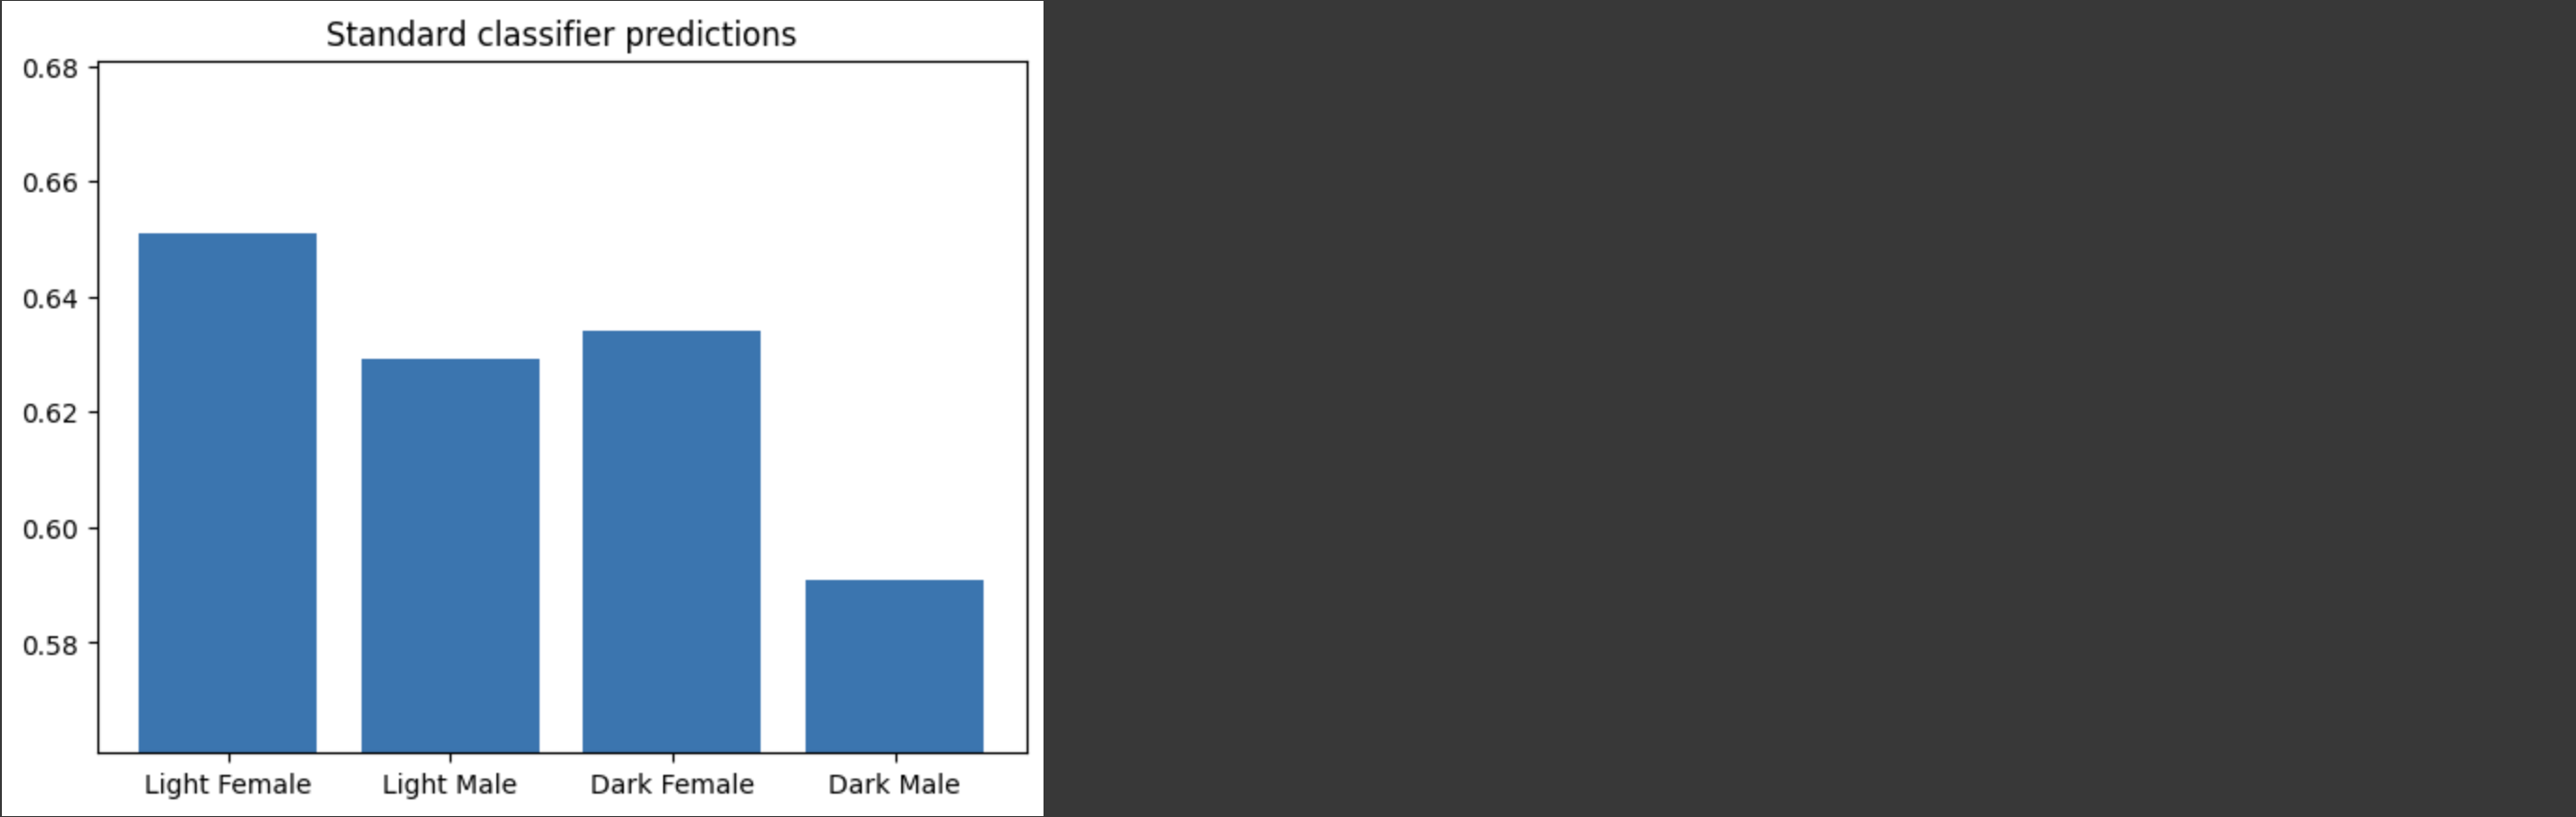

B. DB-VAE 模型測試結果，可以發現稀有群組的精確度得到修正，同時原數量大的群組的精確度也不會被減少。

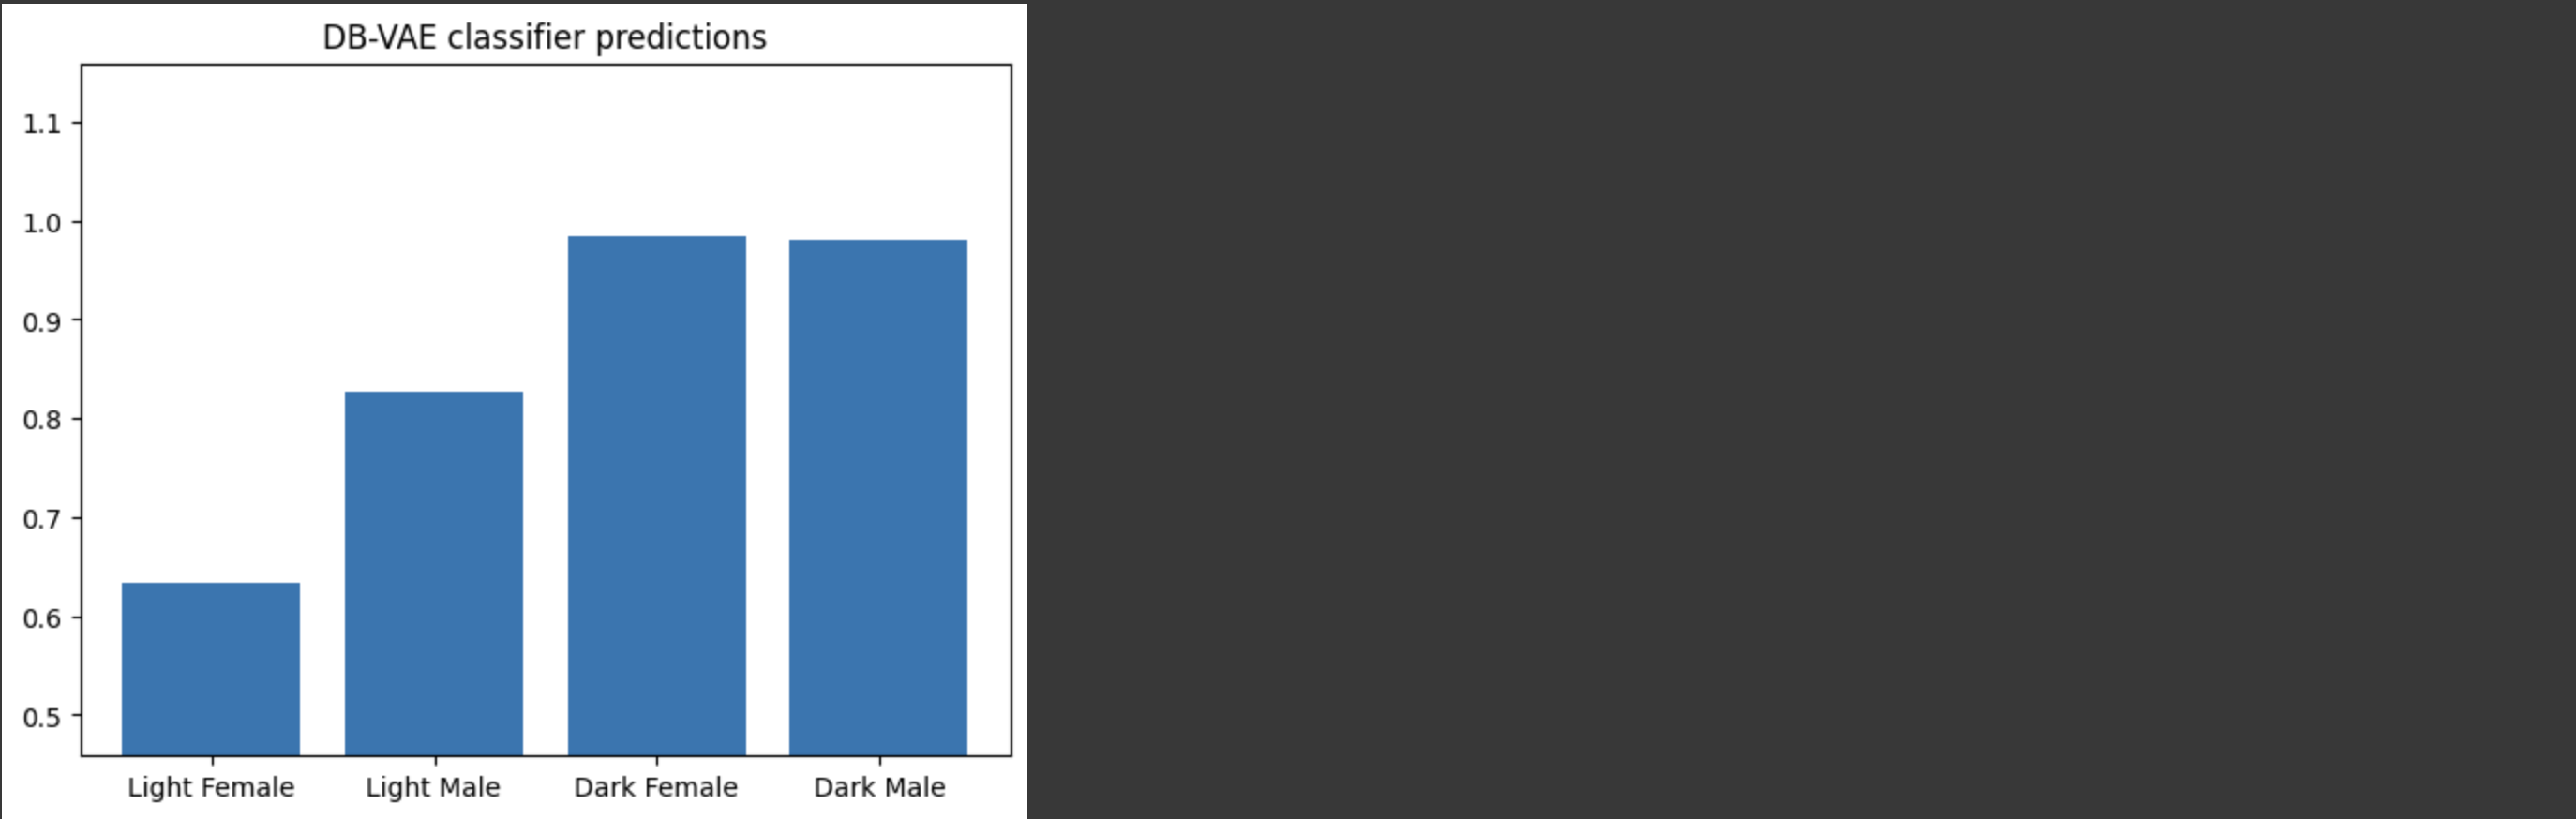

計算偏差分數，觀察採樣的概率分佈。輔以確認 DB-VAE 模型訓練的精準度。

In [ ]:
# 計算輸入圖像 Batch 均值
def get_latent_mu(images, dbvae, batch_size=1024):
  num = images.shape[0]
  mu = np.zeros((num, dbvae.latent_dim))

  for start_ind in range(0, num, batch_size):
    end_ind = min(start_ind + batch_size, num + 1)
    batch = (images[start_ind: end_ind]).astype(np.float32) / 255.
    _, batch_mu, _ = dbvae.encode(batch)
    mu[start_ind: end_ind] = batch_mu

  return mu

def get_training_sample_probabilities(images, dbvae, bins=10, smoothing_fac=0.001):
    mu = get_latent_mu(images, dbvae)

    training_sample_p = np.zeros(mu.shape[0])

    # 考量各潛在變數的分佈
    for i in range(dbvae.latent_dim):

        # 第 i 個潛在分佈
        latent_distribution = mu[:,i]

        hist_density, bin_edges =  np.histogram(latent_distribution, density=True, bins=bins)

        # 找到每個數據樣本屬於哪個潛在 bin
        bin_edges[0] = -float('inf')  # 將第一個邊界設定為負無窮大以確保最小的潛在分佈值能分配到第一個 bin
        bin_edges[-1] = float('inf')  # 將最後一個邊界設定為無窮大以確保最大的潛在分佈值能分配到最後一個 bin

        # 將每個樣本的潛在值映射到對應的區間索引
        bin_idx = np.digitize(latent_distribution, bin_edges)

        # smooth the density function
        hist_smoothed_density = hist_density + smoothing_fac
        hist_smoothed_density /= np.sum(hist_smoothed_density)

        p = hist_smoothed_density[bin_idx - 1]
        # 確保每個訓練樣本的概率不會過小
        training_sample_p = np.maximum(training_sample_p, p)

    # 正規化，以確保所有概率的總和為 1
    training_sample_p /= np.sum(training_sample_p)

    return training_sample_p

In [ ]:
test_images, test_labels = loader.get_test_data(10000)
all_faces = test_images[np.squeeze(np.where(test_labels == 1))[0]]

indices=[2002 1069 2768 ... 1254 1235 4999]


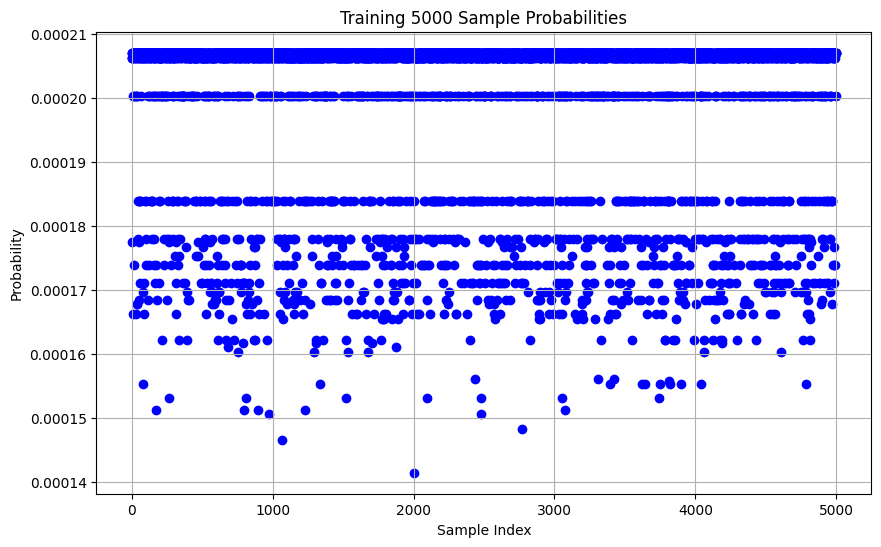

Samples with the highest sampling probabilities


Samples with the lowest sampling probabilities


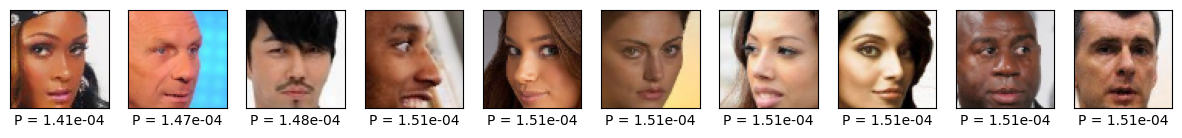

In [ ]:
p_faces = get_training_sample_probabilities(all_faces, db_vae)
indices = np.argsort(p_faces, axis=None)
all_faces = all_faces[indices]
p_faces = p_faces[indices]

print(f'indices={indices}')

# 檢視所有人臉出現的機率分佈
plt.figure(figsize=(10, 6))
plt.scatter(indices, p_faces, color='blue', marker='o')
plt.title(f'Training {len(all_faces)} Sample Probabilities')
plt.xlabel('Sample Index')
plt.ylabel('Probability')
plt.grid(True)
plt.show()

# 潛在變數最大的前十名排列（大到小）
fig, axs = plt.subplots(1, 10, figsize = (15, 12))
for i in range(1, 11):
  axs[i - 1].set_xticks([])
  axs[i - 1].set_yticks([])
  axs[i - 1].grid(False)
  axs[i - 1].imshow(all_faces[- 1 * i])
  axs[i - 1].set_xlabel(f'P = {p_faces[- 1 * i]:.2e}')
print("Samples with the highest sampling probabilities")
plt.show()

# 潛在變數最小的前十名排列（小到大）
fig, axs = plt.subplots(1, 10, figsize = (15, 12))
for i in range(10):
  axs[i].set_xticks([])
  axs[i].set_yticks([])
  axs[i].grid(False)
  axs[i].imshow(all_faces[i])
  axs[i].set_xlabel(p_faces[i])
  axs[i].set_xlabel(f'P = {p_faces[i]:.2e}')
print("Samples with the lowest sampling probabilities")
plt.show()

測試 2：取測試資料進行人臉辨識

In [ ]:
test_images, test_labels = loader.get_test_data(5000)
predictions = db_vae.predict(test_images.astype(np.float32))

隨機取 20 筆測試資料觀察分類結果是否正確

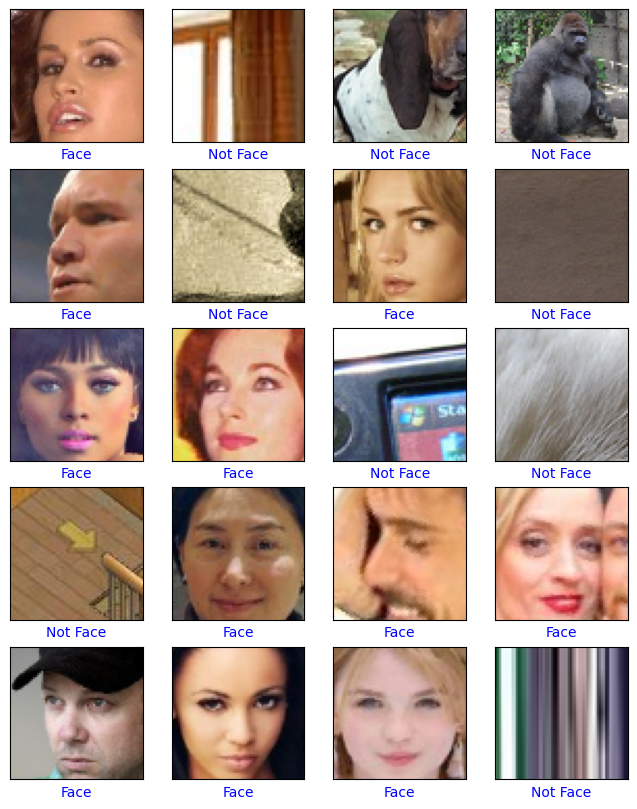

In [ ]:
num_rows = 5
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, num_cols, i + 1)
  pick_idx = np.random.randint(low=0, high=len(predictions))
  pred_val = np.round(tf.nn.sigmoid(predictions[pick_idx]))
  plt.xticks([])
  plt.yticks([])
  plt.xlabel('Face' if pred_val == 1 else 'Not Face', color='blue')
  plt.imshow(test_images[pick_idx])